<a href="https://colab.research.google.com/github/majavier26/DSProjects/blob/main/Term%20deposit%20prediction/Term_deposit_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
! pip install shap
! pip install xgboost

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shap

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

In [40]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Term deposit prediction

[This dataset](https://archive.ics.uci.edu/dataset/222/bank+marketing) comes from UC Irvine Machine Learning Repository and it involves classifying if a client will avail a term deposit from a handful of input variables. We have 16 input variables:
- age (numeric)
- job (categorical)
- marital status (categorical)
- education (categorical)
- default history (binary)
- average yearly balance (binary)
- existence of housing loan (binary)
- contact communication type (categorical)
- last contact day of the month (numeric)
- last contact month of the year (categorical)
- last contact duration (numeric)
- number of contacts performed (numeric)
- days that passed after client was last contacted in this campaign (numeric)
- previous number of contacts before this campaign
- outcome of previous marketing campaign

and one output variable: whether a client has availed a term deposit.

### Exploratory data analysis

#### Preliminary checking
Let's import the dataset.

In [41]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Term deposit availing prediction/Data/bank.csv', sep=';')
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


Although the website says that there are no null values, let's still check it for good measure.

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


Now let's see the relevant statistical metrics for this dataset. We already know that the dataset contains 4521 rows and it indeed does, shown in the `count` row.

We also see in the `age column` that the minimum age is 19 years old, barely pass the legal age, and that the maximum age is 87 years old. It must be noted that the opposite sides of the age spectrum is correlated with risky behavior.

We also see the opposite behaviors in the `balance` column where the minimum balance is -€3313 while the maximum balance is +€4521.

In [43]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


Let's try checking if there may be confounding variables in our numerical data by visualizing the correlation matrix.

In [44]:
data_numerical = data.select_dtypes(include=np.number) # gets the columns with numerical data
data_corr_matrix = data_numerical.corr()
data_corr_matrix.style.background_gradient(cmap='coolwarm')

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.083820,-0.017853,-0.002367,-0.005148,-0.008894,-0.003511
balance,0.083820,1.000000,-0.008677,-0.015950,-0.009976,0.009437,0.026196
day,-0.017853,-0.008677,1.000000,-0.024629,0.160706,-0.094352,-0.059114
duration,-0.002367,-0.015950,-0.024629,1.000000,-0.068382,0.010380,0.018080
campaign,-0.005148,-0.009976,0.160706,-0.068382,1.000000,-0.093137,-0.067833
pdays,-0.008894,0.009437,-0.094352,0.010380,-0.093137,1.000000,0.577562
previous,-0.003511,0.026196,-0.059114,0.018080,-0.067833,0.577562,1.000000


We can see that there is a mildly positive correlation between the columns `pdays` and `previous`, and that does make sense as both are dependent on the time period that the client was contacted before the current campaign. We can remove that column in our dataset when we do our analyses on it.

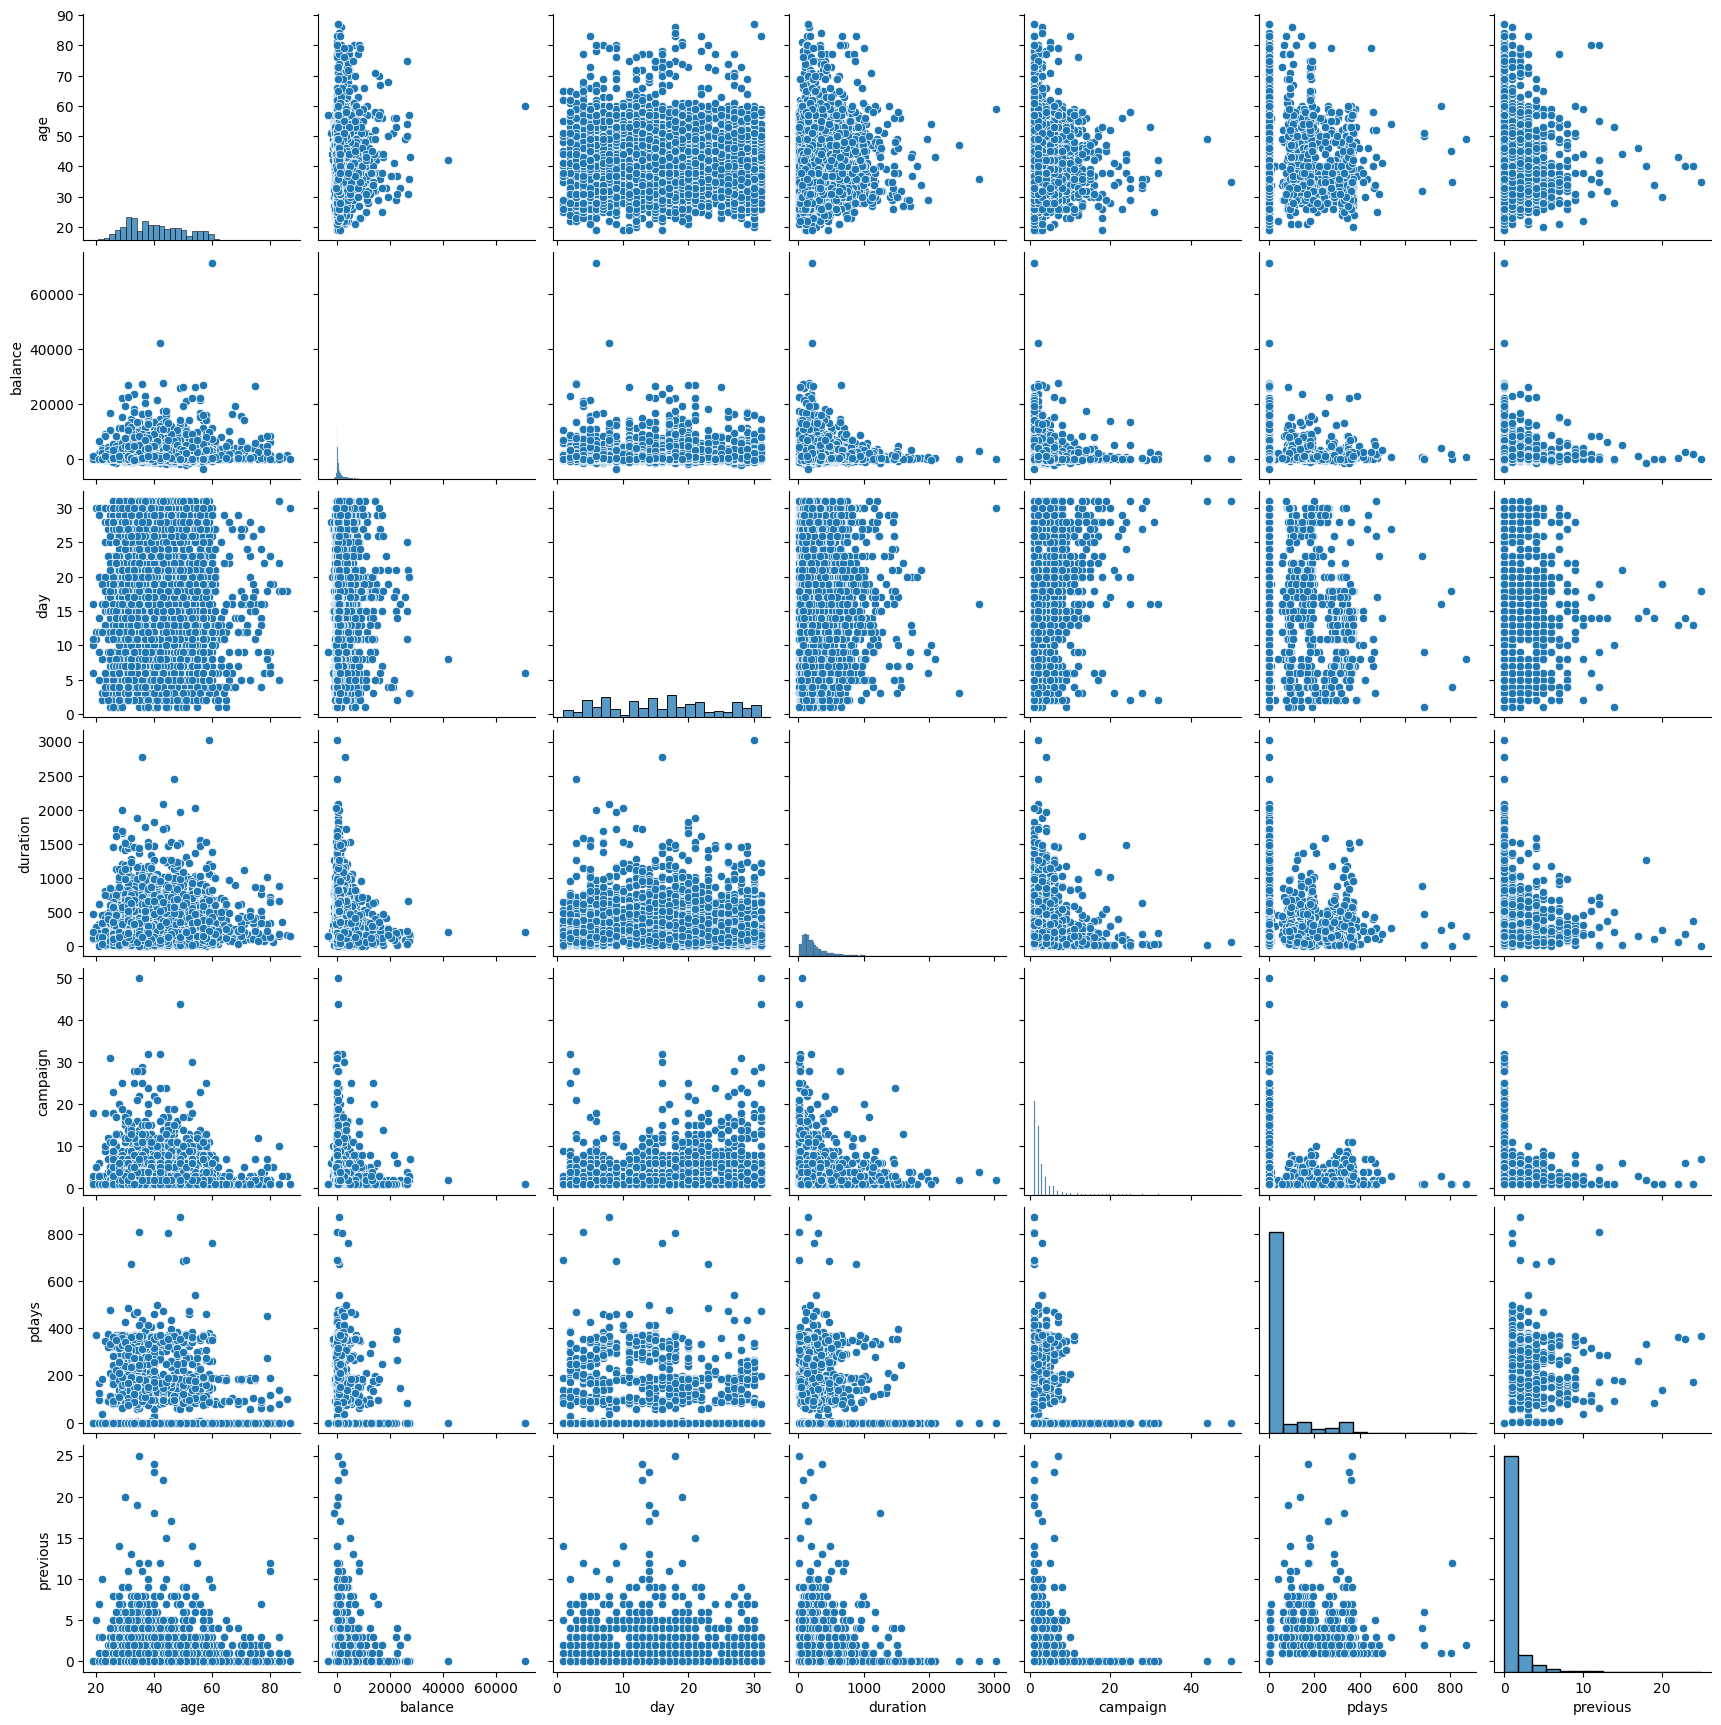

<Figure size 640x480 with 0 Axes>

In [45]:
sns.pairplot(data)
plt.show()
plt.savefig('pairplot.png', dpi=300)

### Observing the data

Now that our data is initialized, we can observe the relationships of the variables with each other.

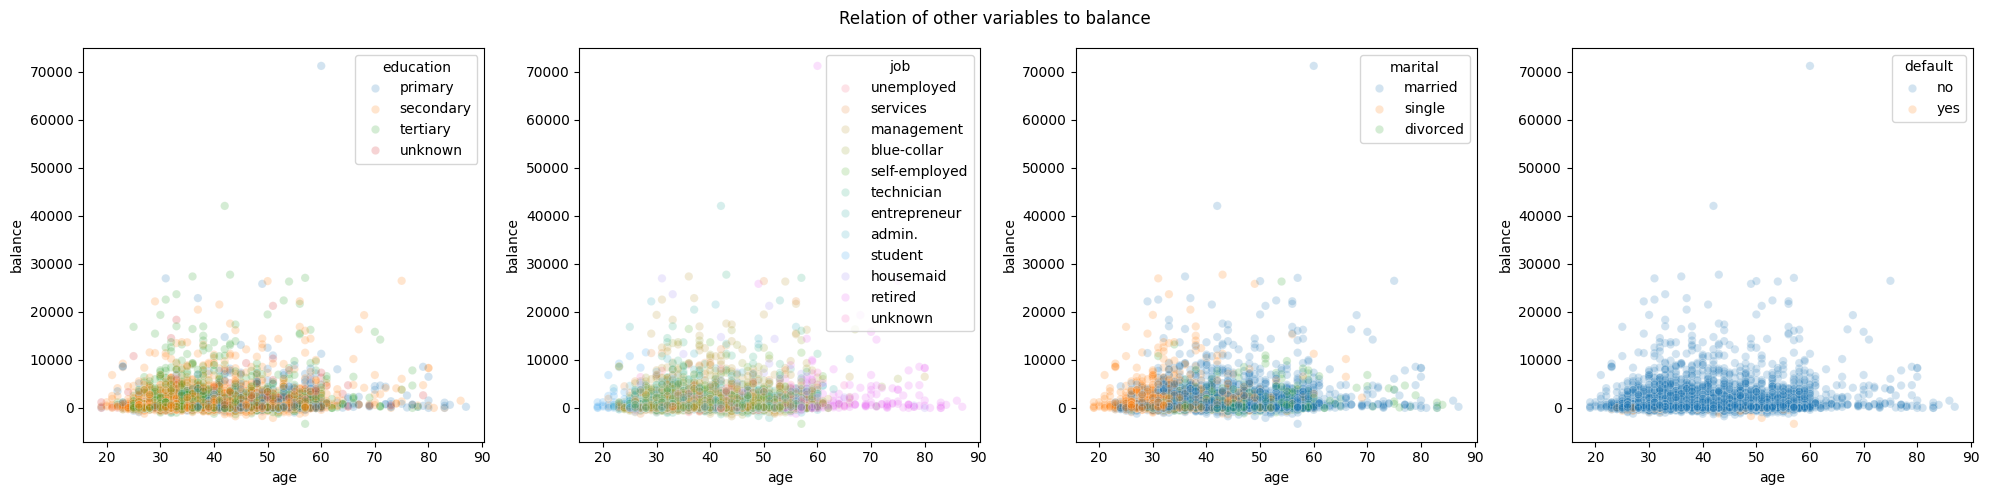

In [46]:
plt.figure(figsize=(20, 5))
plt.suptitle('Relation of other variables to balance')
for idx, var in enumerate(['education', 'job', 'marital', 'default']):
    plt.subplot(1, 4, idx+1)
    sns.scatterplot(data=data, x='age', y='balance', hue=var, alpha=0.2)
plt.tight_layout()
plt.show()
# plt.savefig('age_balance.png', dpi=300

Now, we can also closely observe how some variables can correlate with the occurence of clients availing a term deposit. The distribution is right-skewed as middle-aged people are generally the largest clientele of banks. We can also see a sharp drop in counts when `age > 60` as the retirement age is either 60 or 65 year old.

We can observe that age range is 19-87 and mean age is ~41. However,

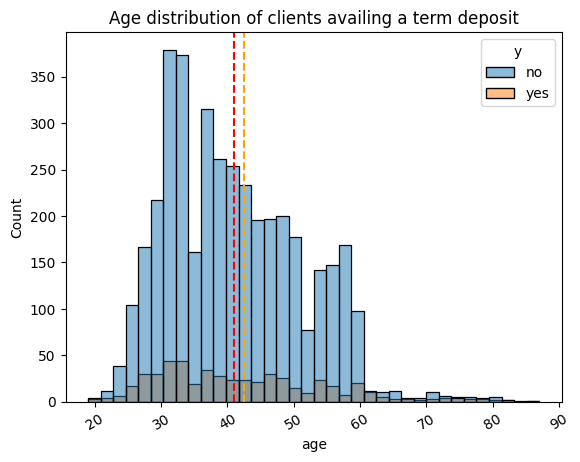

In [47]:
sns.histplot(data=data, x='age', hue='y')
mean_age_no, mean_age_yes = tuple(data['age'].groupby(data['y']).mean())
plt.title('Age distribution of clients availing a term deposit')
plt.axvline(x=mean_age_no, color='red', linestyle='--', label='Mean age')
plt.axvline(x=mean_age_yes, color='orange', linestyle='--', label='Mean age')
# plt.text(x=0, y=0, s=f' Mean \n{np.round(mean_age, 2)}', horizontalalignment='center', verticalalignment='center')
plt.xticks(rotation=30, fontsize=10)
plt.show()

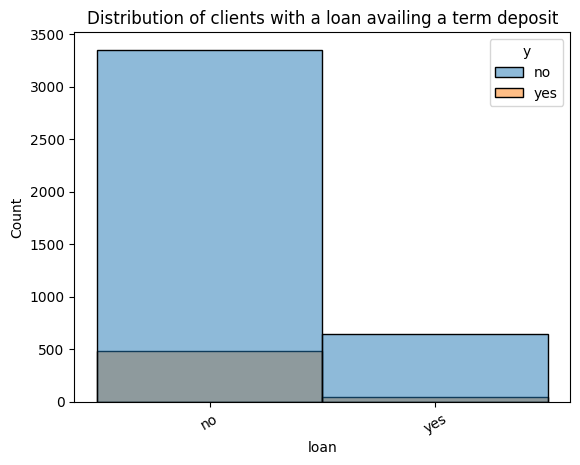

In [48]:
sns.histplot(data=data, x='loan', hue='y', binwidth=0.8)
plt.title('Distribution of clients with a loan availing a term deposit')
plt.xticks(rotation=30, fontsize=10)
plt.show()

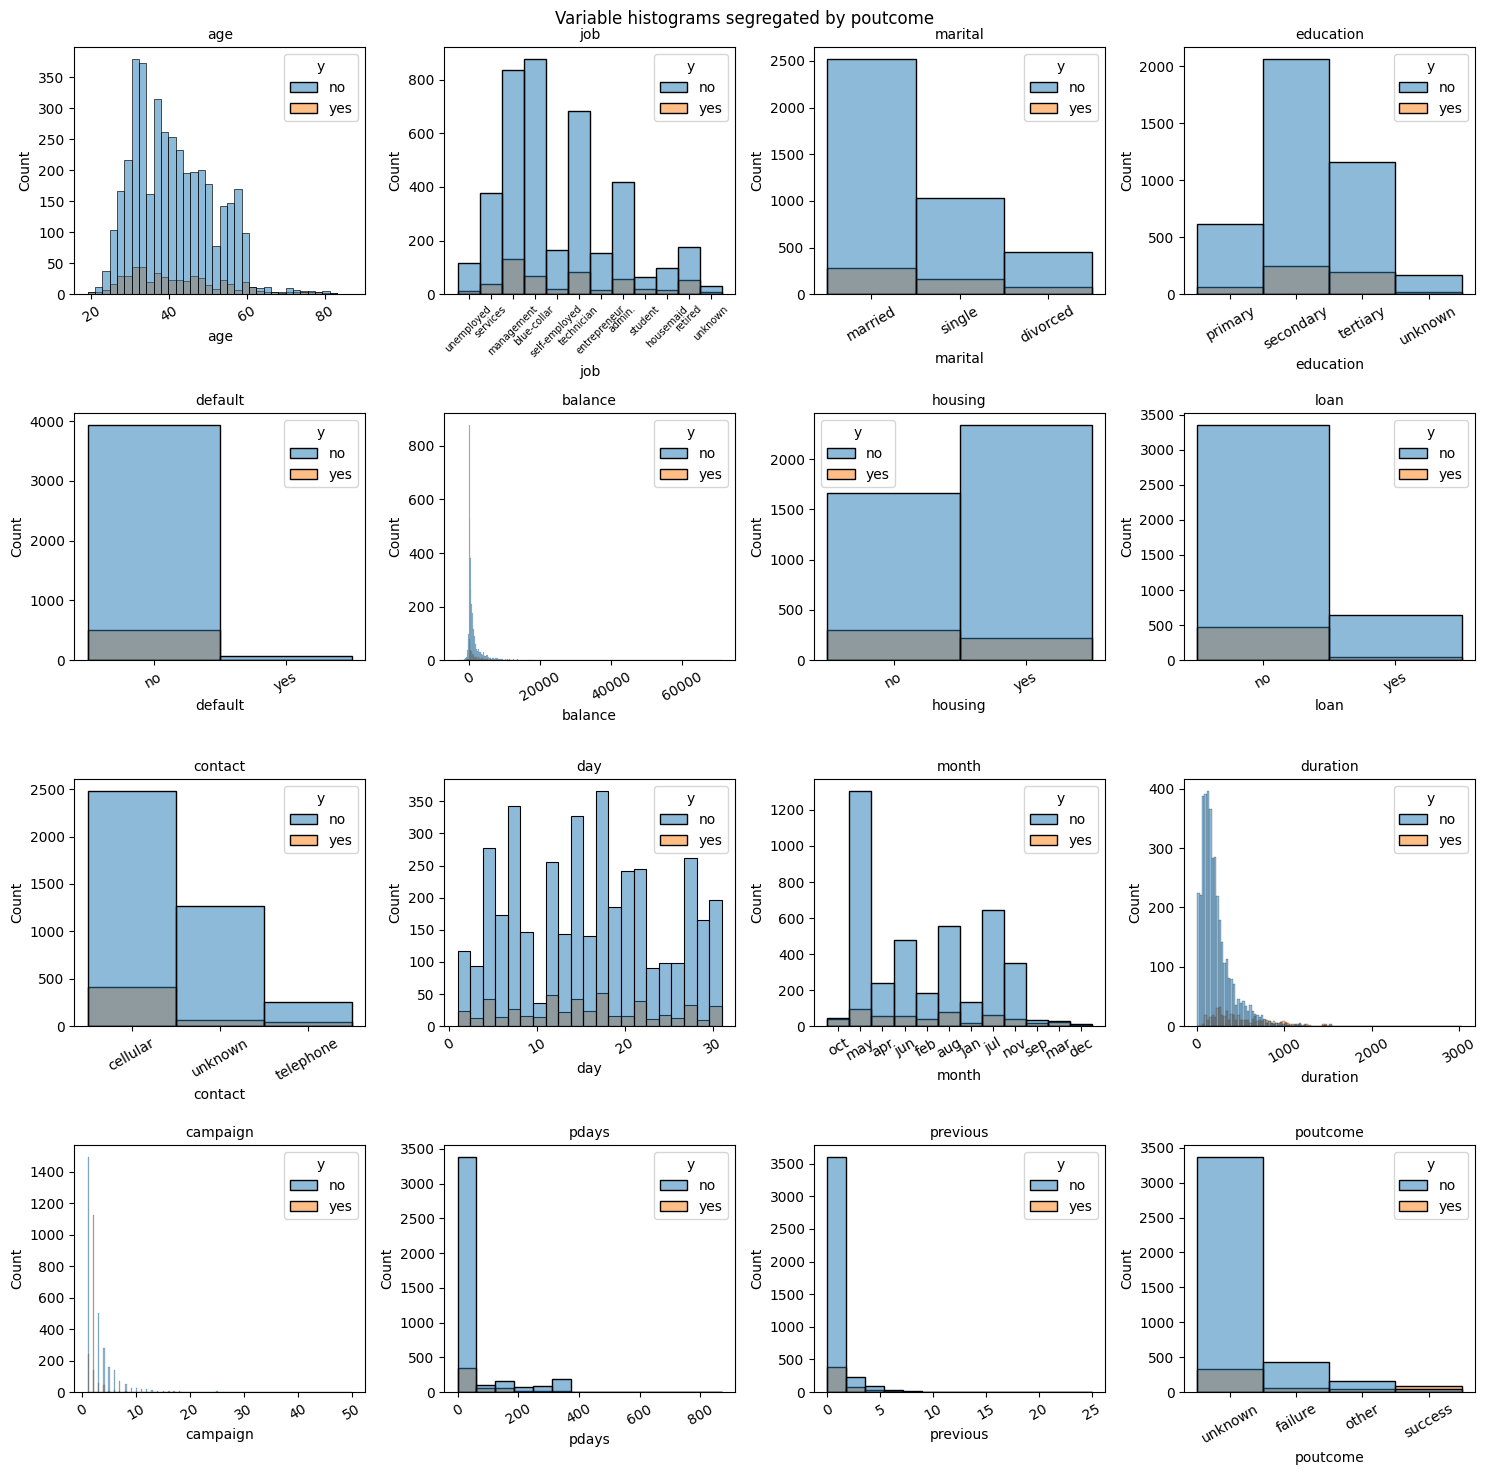

In [49]:
feature_columns = data.columns[:-1]

plt.figure(figsize=(15, 15))
plt.suptitle('Variable histograms segregated by poutcome')
for idx, var in enumerate(feature_columns):
  plt.subplot(4, 4, idx+1)
  sns.histplot(data=data, x=var, hue='y')
  plt.title(var, fontsize=10)
  if idx == 1:
    font_size, angle = 7, 45
  else:
    font_size, angle = 10, 30
  plt.xticks(rotation=angle, fontsize=font_size)
plt.tight_layout()
plt.show()

### Preprocessing data

#### Encoding categorical data
Since our data contains categorical and binary variables, we have to convert them into numerical ones so that our ML models could understand them. We have the choice of converting our variables between one-hot encoding and label encoding, however we will choose the former as our variables are not in order (except `month`).

In [50]:
data_target = data['y']
data_features = data.iloc[:, :-1]

In [51]:
num_features = data_features.select_dtypes(include=np.number)
cat_features = data_features.select_dtypes(include=object)

##### **Numerical features**

From the summary earlier, the `balance` column has a lot of range while the other columns does not possess that same range. This will result in `balance` influencing the algorithm more as it has bigger values. What we should do is to standardize the data so that every feature has equal weight.

In [52]:
scaler = MinMaxScaler()
num_features_new = pd.DataFrame(scaler.fit_transform(num_features), columns=num_features.columns)
num_features_new

,age,balance,day,duration,campaign,pdays,previous
0,0.161765,0.068455,0.600000,0.024826,0.000000,0.000000,0.00
1,0.205882,0.108750,0.333333,0.071500,0.000000,0.389908,0.16
2,0.235294,0.062590,0.500000,0.059914,0.000000,0.379587,0.04
3,0.161765,0.064281,0.066667,0.064548,0.061224,0.000000,0.00
4,0.588235,0.044469,0.133333,0.073486,0.000000,0.000000,0.00
...,...,...,...,...,...,...,...
4516,0.205882,0.039999,0.966667,0.107580,0.081633,0.000000,0.00
4517,0.558824,0.000000,0.266667,0.049321,0.000000,0.000000,0.00
4518,0.558824,0.048429,0.600000,0.048659,0.204082,0.000000,0.00
4519,0.132353,0.059731,0.166667,0.041377,0.061224,0.243119,0.12


**Categorical features**

For the categorical features, we may want to use `data_features.select_dtypes(include=object)` for ease of use, and well yes, but it doesn't aid us when we interpret it. The way the aforementioned code works is it takes all of the unique values in an array, and assign values to all of the unique values.

For the "true" categorical features such as `job`, the labels can be arbitrary, but for the boolean columns and `month`, it can prove to give unexpected results. The value `no` can be labeled as `1` and vice-versa. For `month`, since there is an established order for months, it would help that the months are labeled ordinally.

That is why we will separate the categorical columns into three:
- "true" categories: `job`, `marital`, `education`, `education`, `contact`, `poutcome`
- boolean: `default`, `housing`, `loan`
- ordinal: `month`

In [89]:
cat_features = data_features[['job', 'marital', 'education', 'contact', 'poutcome']]
bool_features = data_features[['default', 'housing', 'loan']]
ordinal_features = data_features['month']

For cat_features, we can encode them using `LabelEncoder()` from `sklearn.preprocessing`.

In [91]:
cat_columns = cat_features.columns
label_encoder = LabelEncoder()
cat_encoded_list = [label_encoder.fit_transform(cat_features[col]) for col in cat_columns]
cat_encoded_df = pd.DataFrame({cat_columns[idx]:cat_encoded_list[idx] for idx, col in enumerate(cat_columns)})
cat_encoded_df

,job,marital,education,contact,poutcome
0,10,1,0,0,3
1,7,1,1,0,0
2,4,2,2,0,0
3,4,1,2,2,3
4,1,1,1,2,3
...,...,...,...,...,...
4516,7,1,1,0,3
4517,6,1,2,2,3
4518,9,1,1,0,3
4519,1,1,1,0,1


For `bool_features`, we can reuse what we did on `data_target`

In [ ]:
f

Now, we have to convert these categorical columns into something that the ML algorithm can understand. We'll use label encoding to assign arbitrary numbers to all of the unique categories in a specific column. That is why we can see '8' in the `month` column for row 1 even though it's actually `may`, which is the 5th month.

In [ ]:
pd.to_datetime(data['month'], format='%b').dt.month

Then we can concatenate the numerical features `num_features` and the encoded categorical features `cat_encoded_df`.

In [55]:
data_features_new = pd.concat([num_features, cat_encoded_df], axis=1)
data_features_new.corr().style.background_gradient(cmap='coolwarm')

,age,balance,day,duration,campaign,pdays,previous,job,marital,education,default,housing,loan,contact,month,poutcome
age,1.000000,0.083820,-0.017853,-0.002367,-0.005148,-0.008894,-0.003511,-0.021500,-0.381485,-0.121613,-0.017885,-0.193888,-0.011250,0.015161,-0.040714,-0.009320
balance,0.083820,1.000000,-0.008677,-0.015950,-0.009976,0.009437,0.026196,0.009797,0.024971,0.057725,-0.070886,-0.050227,-0.071349,-0.009665,0.023113,-0.029268
day,-0.017853,-0.008677,1.000000,-0.024629,0.160706,-0.094352,-0.059114,0.012865,0.008794,0.014926,-0.013261,-0.031291,-0.004879,-0.033807,-0.014795,0.073714
duration,-0.002367,-0.015950,-0.024629,1.000000,-0.068382,0.010380,0.018080,-0.006739,0.006619,-0.014878,-0.011615,0.015740,-0.004997,-0.011380,0.000851,0.000478
campaign,-0.005148,-0.009976,0.160706,-0.068382,1.000000,-0.093137,-0.067833,-0.002739,0.005915,-0.001723,-0.012348,-0.003574,0.017120,0.012278,-0.108915,0.110703
pdays,-0.008894,0.009437,-0.094352,0.010380,-0.093137,1.000000,0.577562,-0.022760,0.017050,0.012077,-0.026317,0.116893,-0.031086,-0.243223,0.033292,-0.859245
previous,-0.003511,0.026196,-0.059114,0.018080,-0.067833,0.577562,1.000000,0.005029,0.038028,0.023983,-0.026656,0.038621,-0.022115,-0.187232,0.046899,-0.636372
job,-0.021500,0.009797,0.012865,-0.006739,-0.002739,-0.022760,0.005029,1.000000,0.069390,0.170160,0.008324,-0.128353,-0.040245,-0.074068,-0.096613,0.013049
marital,-0.381485,0.024971,0.008794,0.006619,0.005915,0.017050,0.038028,0.069390,1.000000,0.102714,-0.020745,-0.029851,-0.045210,-0.068236,-0.035855,-0.027716
education,-0.121613,0.057725,0.014926,-0.014878,-0.001723,0.012077,0.023983,0.170160,0.102714,1.000000,-0.010534,-0.087070,-0.054086,-0.110554,-0.050086,-0.032135


Now that we have turned the categorical columns into numbers, we also have to do that with `data_target`. Since these are booleans, `True=1` and `False=0`.

In [56]:
data_target_new = data_target.replace({'no':0, 'yes':1})

<ipython-input-56-494b2f1a1099>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_target_new = data_target.replace({'no':0, 'yes':1})


Let's examine the shapes of our features and target to see if they have the same length.

In [57]:
print(data_target_new.shape, data_features_new.shape)

(4521,) (4521, 16)


Now, we must split our data with the usual train-test-val split (70:20:10).

In [66]:
# Splitting data with 70:30 first
x_train, x_test, y_train, y_test = train_test_split(data_features_new, data_target_new, test_size = 0.3, random_state=26)

### Modeling the data

#### Random forest algorithm

In [67]:
# Initializing the random forest algorithm and fitting
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

# Predicting the test result
y_pred_rfc = rfc.predict(x_test)

Now, let's see how the model is performing by comparing the true test values by the predicted values. We can see that most of the rows are equal, meaning our model may be good, however it would be really inefficient if we check the values of each row one by one. That is why we will make a confusion matrix to see the performance of our model.

In [68]:
# Make a comparison dataframe
pred_compare_rfc = pd.DataFrame({'True value':y_test, 'Predicted value':y_pred_rfc})
pred_compare_rfc.head(10)

,True value,Predicted value
4385,0,0
572,0,0
2173,0,0
3291,0,0
2256,0,0
3915,0,0
462,0,0
3900,0,0
4300,1,0
2157,0,0


Making a confusion matrix, we get this.

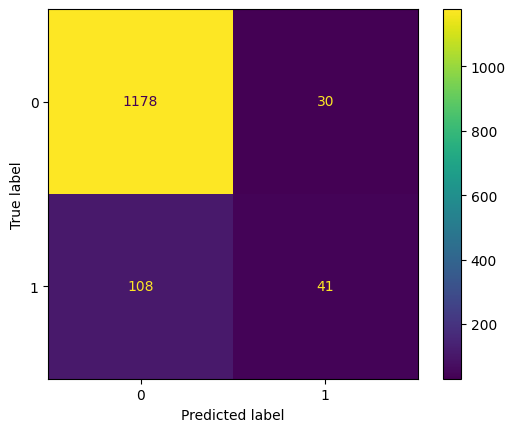

In [69]:
# Making the confusion matrix and plotting it
conf_mat = confusion_matrix(y_test, y_pred_rfc)
ConfusionMatrixDisplay(conf_mat, display_labels=rfc.classes_).plot()
plt.show()

#### XGBoost Regressor

In [76]:
# Initializing the XGBoost regressor
xgbr = XGBClassifier(objective='reg:squarederror')
xgbr.fit(x_train, y_train)

# Predicting with test values
y_pred_xgb = xgbr.predict(x_test)

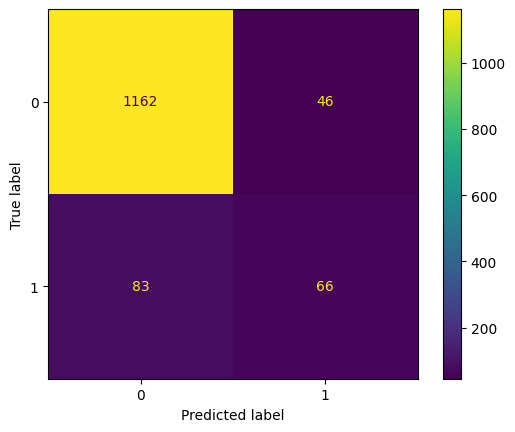

In [77]:
# Making the confusion matrix and plotting it
conf_mat = confusion_matrix(y_test, y_pred_xgb)
ConfusionMatrixDisplay(conf_mat, display_labels=rfc.classes_).plot()
plt.show()

#### SHAP values

[SHAP values](https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137/) or (Shapley Additive Explanations) is a method based on game theory and is mainly used for easier interpretation of machine learning models. We will use this method to provide more context to the results of our model.

In [78]:
explainer_rfc = shap.Explainer(rfc)
shapval_rfc = explainer_rfc(x_train[0:100])

In [79]:
shapval_rfc.shape

(100, 16, 2)

`shapval_rfc` is an Explanation object with shape $n\times16\times2$. We can use a waterfall plot to try to explain how each variable was taken into account in the model, how impactful they are and how they influence the prediction of the class of a datapoint.

Below, we have the waterfall plot of the first sample, and how the variables

In [80]:
shapval_rfc[0]

.values =
array([[ 0.00582008, -0.00582008],
       [-0.01184755,  0.01184755],
       [ 0.00339943, -0.00339943],
       [ 0.06864218, -0.06864218],
       [-0.0034732 ,  0.0034732 ],
       [ 0.00678365, -0.00678365],
       [ 0.010174  , -0.010174  ],
       [ 0.00288066, -0.00288066],
       [-0.00371963,  0.00371963],
       [ 0.00493106, -0.00493106],
       [ 0.00032012, -0.00032012],
       [ 0.01504445, -0.01504445],
       [-0.00093163,  0.00093163],
       [-0.00959381,  0.00959381],
       [ 0.01252644, -0.01252644],
       [-0.00341833,  0.00341833]])

.base_values =
array([0.88246207, 0.11753793])

.data =
array([  33, 5137,    6,  123,    1,   -1,    0,    1,    2,    1,    0,
          1,    0,    0,    8,    3])

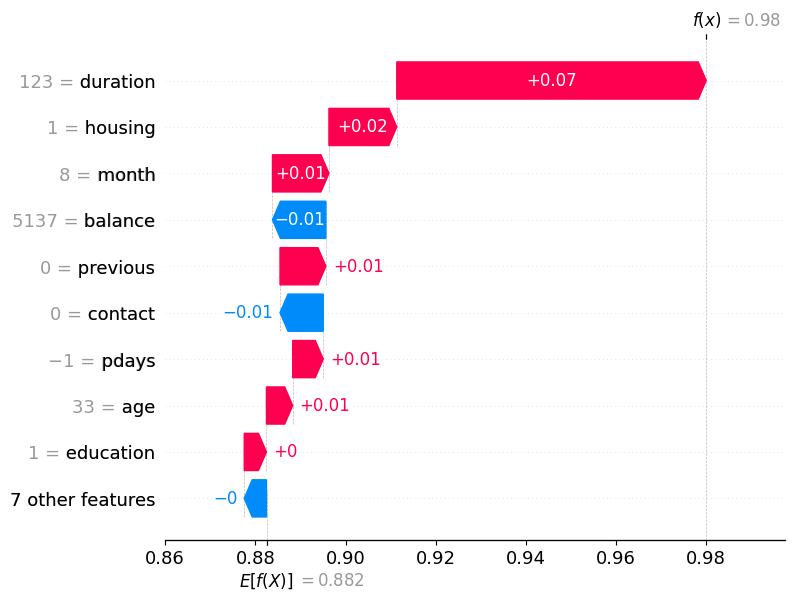

In [81]:
shap.plots.waterfall(shapval_rfc[0, :, 0]) # First sample, first class

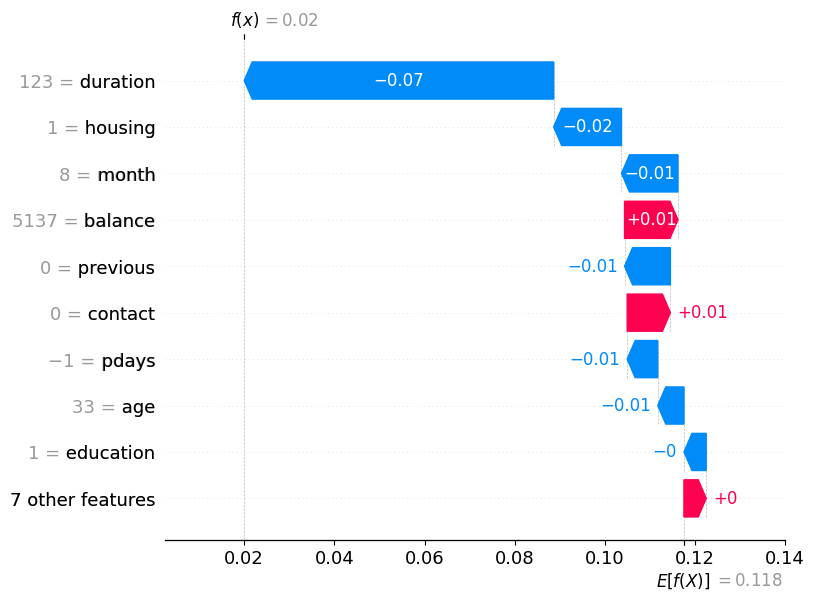

In [82]:
shap.plots.waterfall(shapval_rfc[0, :, 1]) # First sample, second class